In [1]:
!pip install imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import warnings

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve,
                             average_precision_score, f1_score)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline

# For real-time simulation
from collections import deque

# Set random seed for reproducibility
np.random.seed(42)
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('/content/financial_fraud_detection_dataset.csv')


=== Basic Dataset Information ===
Shape: (194990, 18)

Data Types:
transaction_id                  object
timestamp                       object
sender_account                  object
receiver_account                object
amount                         float64
transaction_type                object
merchant_category               object
location                        object
device_used                     object
is_fraud                          bool
fraud_type                      object
time_since_last_transaction    float64
spending_deviation_score       float64
velocity_score                   int64
geo_anomaly_score              float64
payment_channel                 object
ip_address                      object
device_hash                     object
dtype: object

Missing Values:
transaction_id                      0
timestamp                           0
sender_account                      0
receiver_account                    0
amount                              0
transacti

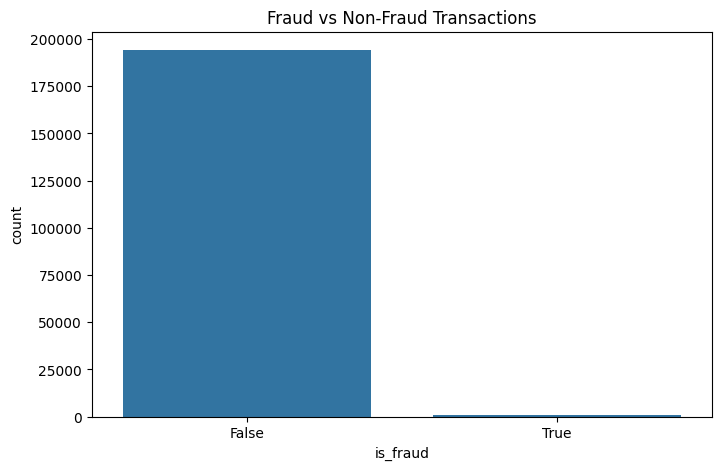


=== Numerical Features Summary ===
              amount  time_since_last_transaction  spending_deviation_score  \
count  194990.000000                 19445.000000             194990.000000   
mean      358.461958                    27.069334                  0.002395   
std       469.259051                  3574.919679                  0.998971   
min         0.010000                 -8680.497974                 -4.630000   
25%        26.650000                 -2523.664262                 -0.670000   
50%       138.400000                    33.831894                  0.000000   
75%       503.487500                  2613.235557                  0.680000   
max      2833.230000                  8706.600354                  4.250000   

       velocity_score  geo_anomaly_score  
count   194990.000000      194990.000000  
mean        10.486081           0.499662  
std          5.769144           0.288589  
min          1.000000           0.000000  
25%          5.000000           0.250

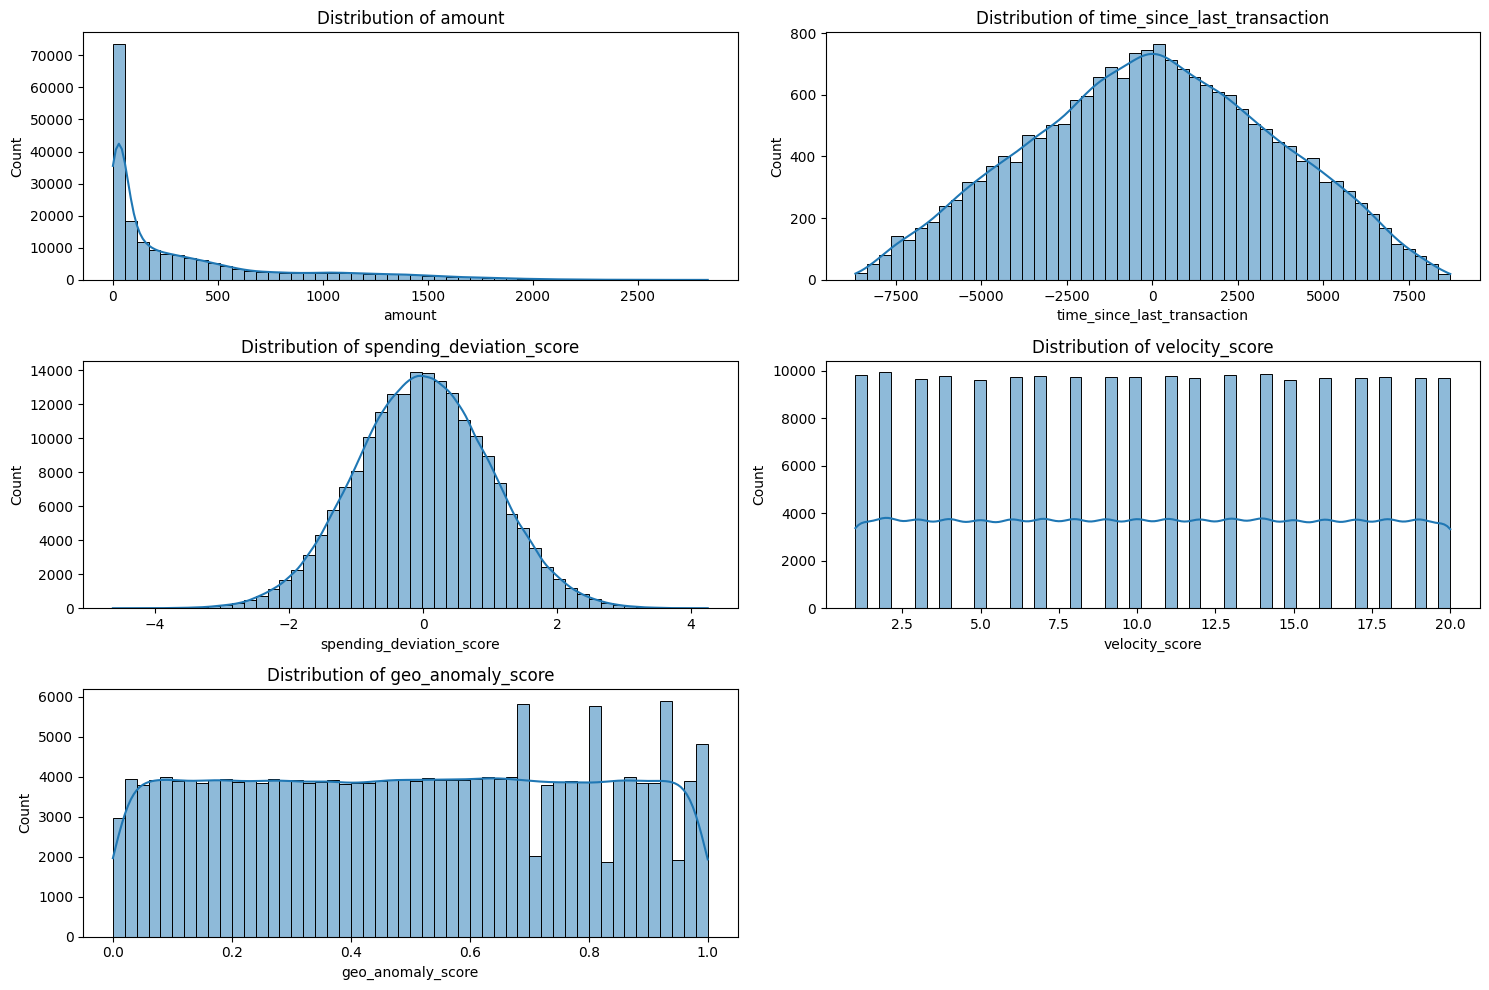


=== transaction_type Distribution ===
transaction_type
transfer      0.251131
deposit       0.249910
payment       0.249603
withdrawal    0.249356
Name: proportion, dtype: float64


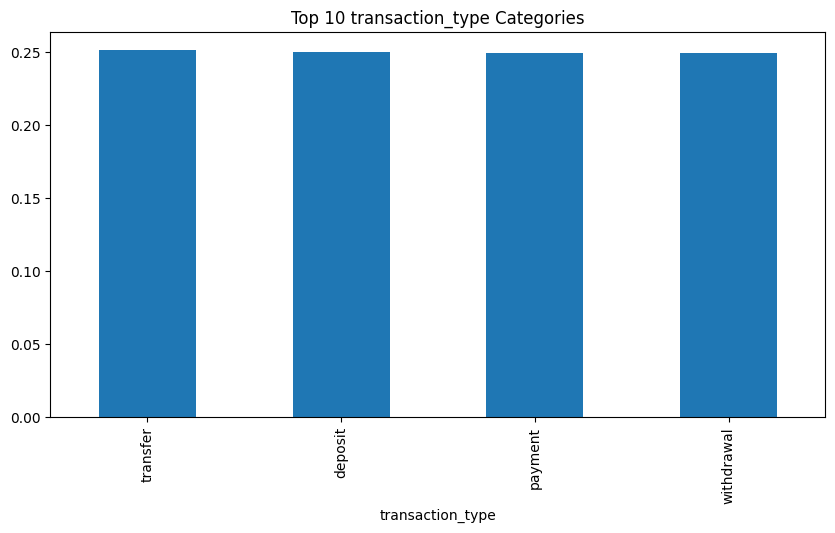


=== merchant_category Distribution ===
merchant_category
retail           0.125960
entertainment    0.125883
utilities        0.125494
grocery          0.125453
other            0.124904
travel           0.124612
restaurant       0.124494
online           0.123201
Name: proportion, dtype: float64


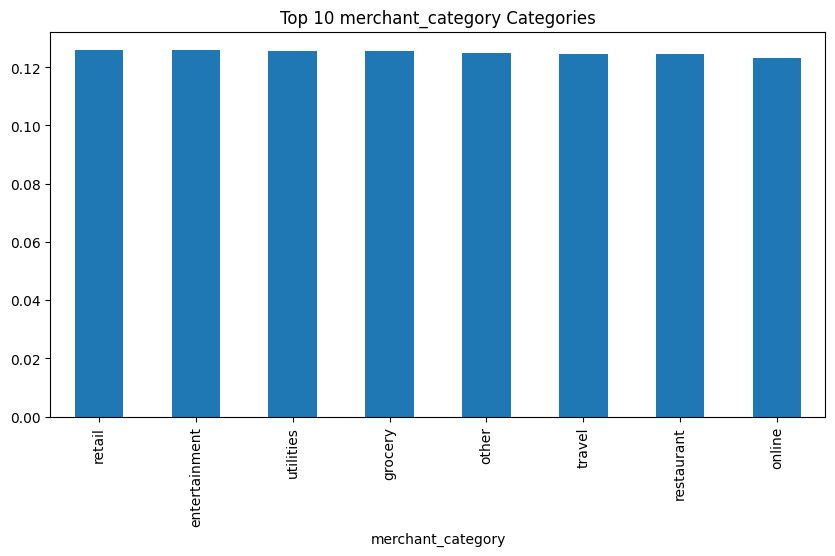


=== location Distribution ===
location
Dubai        0.125863
Tokyo        0.125735
New York     0.125324
Singapore    0.124986
Toronto      0.124924
Sydney       0.124801
Berlin       0.124535
London       0.123832
Name: proportion, dtype: float64


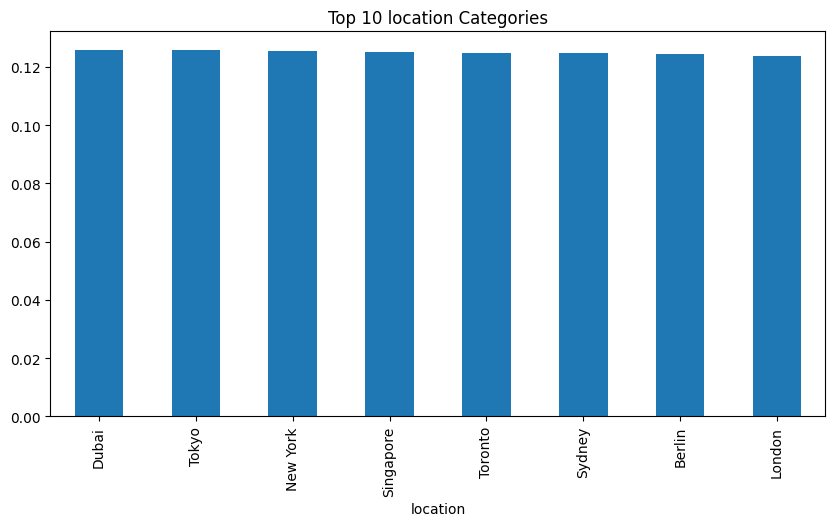


=== device_used Distribution ===
device_used
mobile    0.250572
atm       0.250356
web       0.250064
pos       0.249008
Name: proportion, dtype: float64


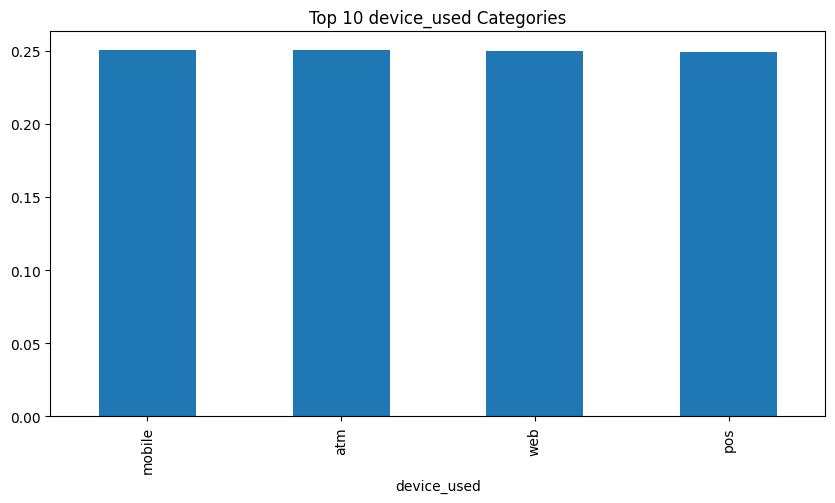


=== payment_channel Distribution ===
payment_channel
card             0.251151
UPI              0.250249
wire_transfer    0.249633
ACH              0.248967
Name: proportion, dtype: float64


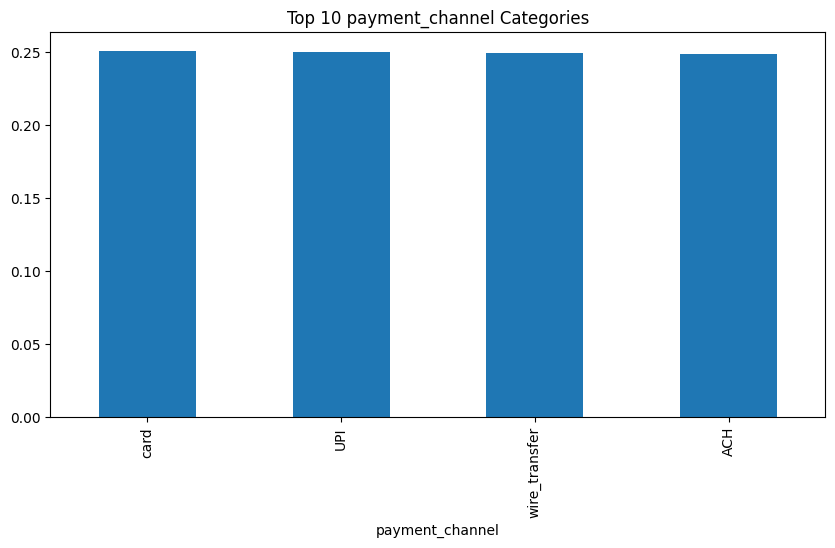

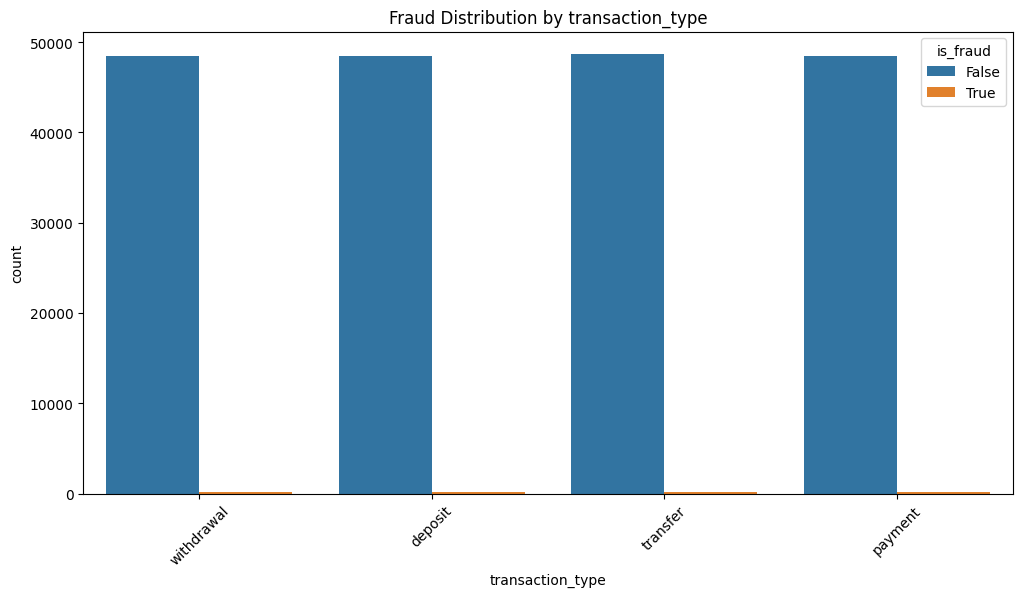

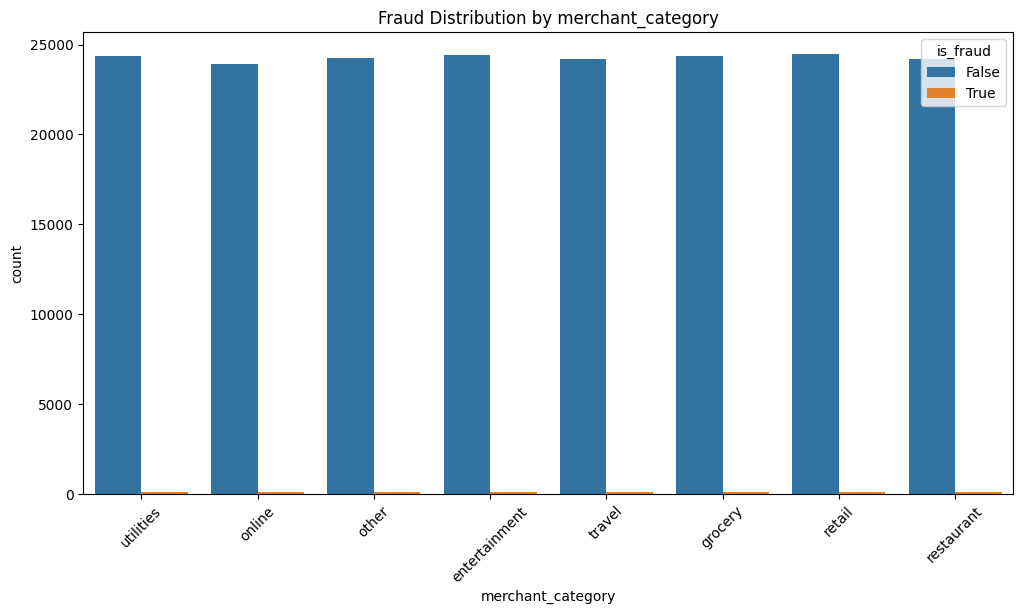

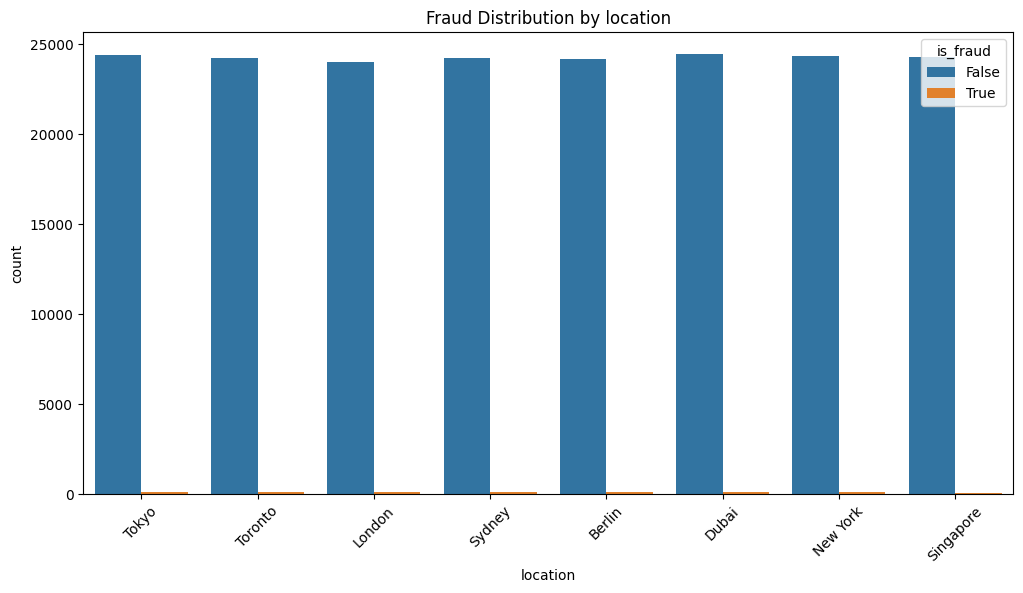

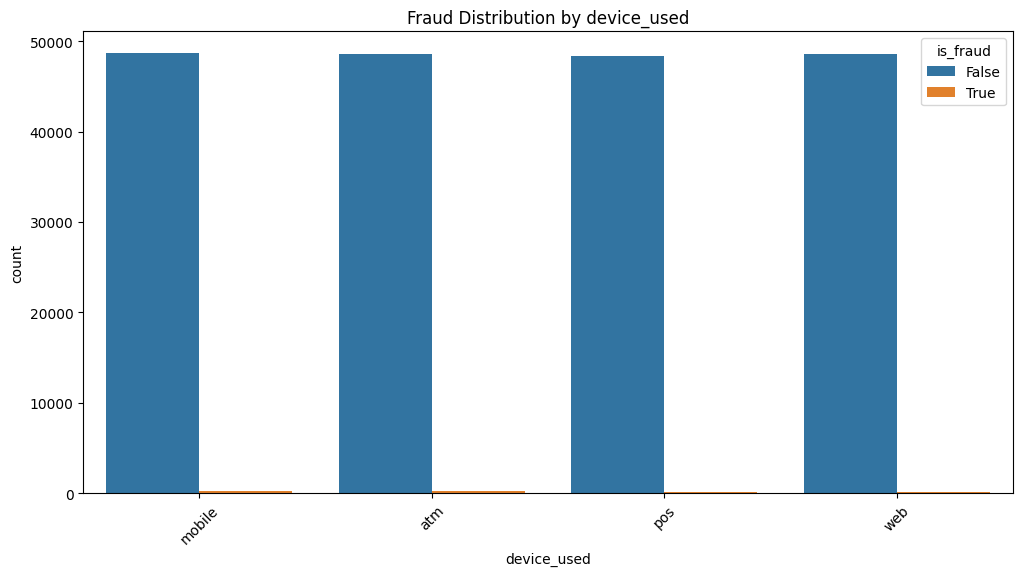

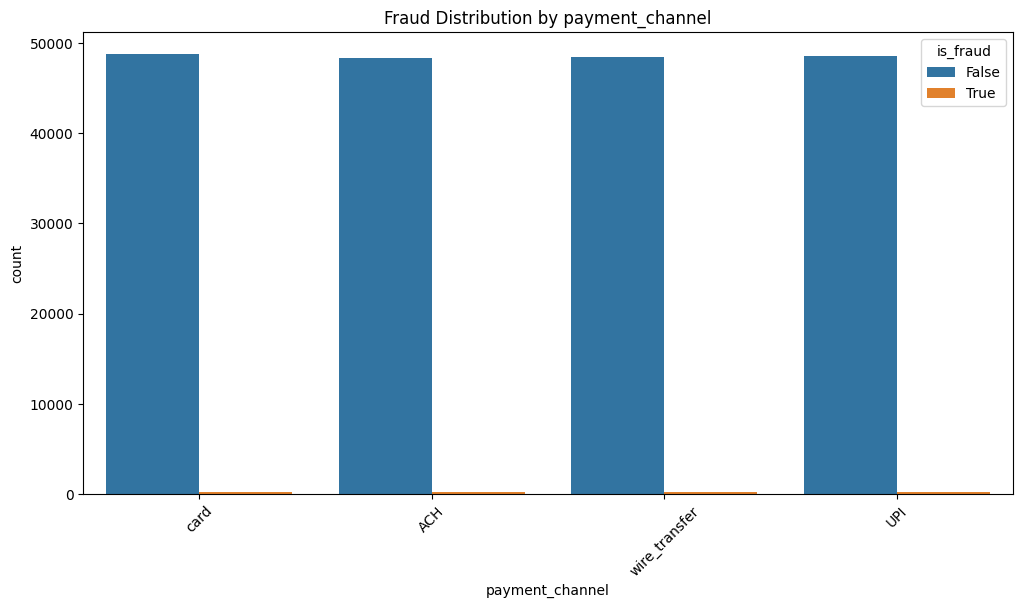

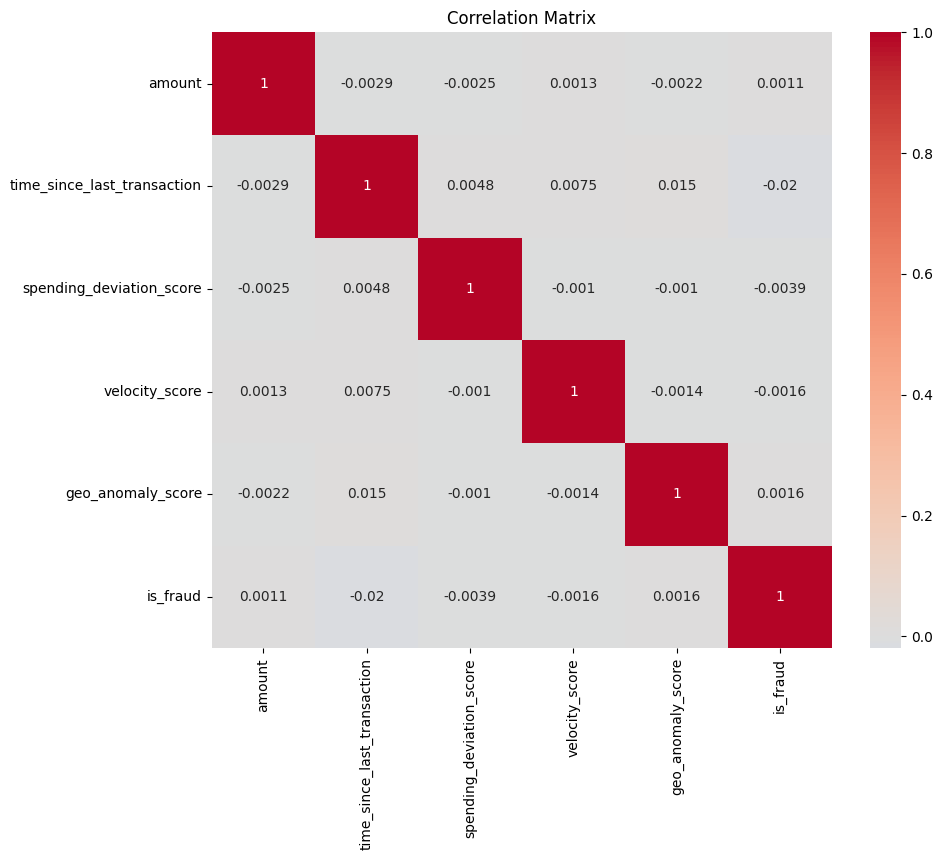

In [2]:
#Exploratory Data Analysis (EDA)
def perform_eda(df):
    print("\n=== Basic Dataset Information ===")
    print(f"Shape: {df.shape}")
    print(f"\nData Types:\n{df.dtypes}")
    print(f"\nMissing Values:\n{df.isnull().sum()}")

    # Fraud distribution
    print("\n=== Fraud Distribution ===")
    fraud_counts = df['is_fraud'].value_counts(normalize=True)
    print(fraud_counts)

    plt.figure(figsize=(8, 5))
    sns.countplot(x='is_fraud', data=df)
    plt.title('Fraud vs Non-Fraud Transactions')
    plt.show()

    # Numerical features analysis
    num_cols = ['amount', 'time_since_last_transaction', 'spending_deviation_score',
                'velocity_score', 'geo_anomaly_score']

    print("\n=== Numerical Features Summary ===")
    print(df[num_cols].describe())

    # Plot distributions of numerical features
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(num_cols, 1):
        plt.subplot(3, 2, i)
        sns.histplot(df[col], bins=50, kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

    # Categorical features analysis
    cat_cols = ['transaction_type', 'merchant_category', 'location',
                'device_used', 'payment_channel']

    for col in cat_cols:
        print(f"\n=== {col} Distribution ===")
        print(df[col].value_counts(normalize=True).head(10))

        # Plot top categories
        plt.figure(figsize=(10, 5))
        df[col].value_counts(normalize=True).head(10).plot(kind='bar')
        plt.title(f'Top 10 {col} Categories')
        plt.show()

    # Fraud by categories
    for col in cat_cols:
        plt.figure(figsize=(12, 6))
        sns.countplot(x=col, hue='is_fraud', data=df)
        plt.title(f'Fraud Distribution by {col}')
        plt.xticks(rotation=45)
        plt.show()

    # Correlation analysis
    plt.figure(figsize=(10, 8))
    corr = df[num_cols + ['is_fraud']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.show()

perform_eda(df)

In [3]:
#Feature Engineering
def preprocess_data(df):
    # Convert timestamp to datetime and extract features
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['day_of_month'] = df['timestamp'].dt.day

    # Handle missing values
    df['time_since_last_transaction'].fillna(-1, inplace=True)
    df['fraud_type'].fillna('legitimate', inplace=True)

    # Feature engineering
    df['amount_log'] = np.log1p(df['amount'])
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

    # Drop unnecessary columns
    df.drop(['transaction_id', 'timestamp', 'sender_account', 'receiver_account',
             'ip_address', 'device_hash'], axis=1, inplace=True)

    return df

df_processed = preprocess_data(df.copy())

In [4]:
def feature_engineering(df):
    # Create interaction features
    df['amount_velocity'] = df['amount'] * df['velocity_score']
    df['geo_spending'] = df['geo_anomaly_score'] * df['spending_deviation_score']

    # Create flags for unusual activity
    df['high_velocity'] = (df['velocity_score'] > df['velocity_score'].quantile(0.95)).astype(int)
    df['high_geo'] = (df['geo_anomaly_score'] > df['geo_anomaly_score'].quantile(0.95)).astype(int)
    df['high_spending'] = (df['spending_deviation_score'] > df['spending_deviation_score'].quantile(0.95)).astype(int)

    # Create time-based features
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    return df

df_features = feature_engineering(df_processed.copy())

In [5]:
# Define features and target
X = df_features.drop('is_fraud', axis=1)
y = df_features['is_fraud']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define numerical and categorical features
numerical_features = ['amount', 'time_since_last_transaction', 'spending_deviation_score',
                     'velocity_score', 'geo_anomaly_score', 'hour', 'day_of_week',
                     'day_of_month', 'amount_log', 'hour_sin', 'hour_cos',
                     'amount_velocity', 'geo_spending']

categorical_features = ['transaction_type', 'merchant_category', 'location',
                       'device_used', 'payment_channel', 'fraud_type']

binary_features = ['high_velocity', 'high_geo', 'high_spending', 'is_night', 'is_weekend']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('binary', 'passthrough', binary_features)
    ])

# Calculate class weights for imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}


=== Training Random Forest ===
Cross-Validation ROC-AUC: 1.0000 ± 0.0000
Training time: 17.86 seconds

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     38833
        True       1.00      1.00      1.00       165

    accuracy                           1.00     38998
   macro avg       1.00      1.00      1.00     38998
weighted avg       1.00      1.00      1.00     38998

Confusion Matrix:
[[38833     0]
 [    0   165]]
ROC-AUC Score: 1.0000


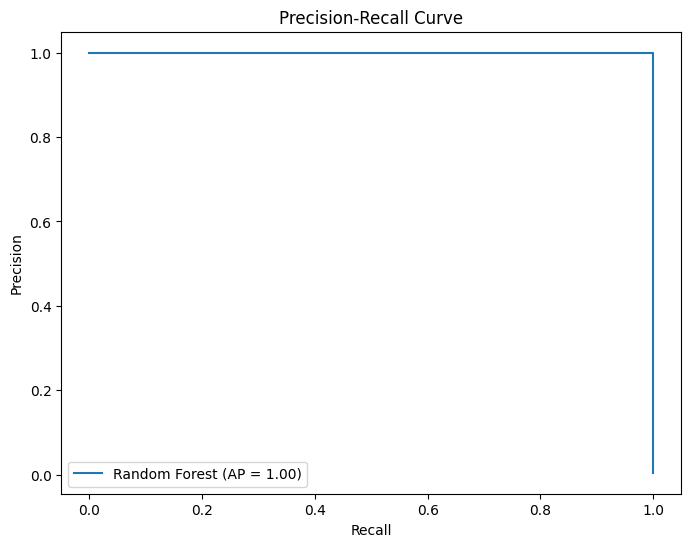


=== Training Gradient Boosting ===
Cross-Validation ROC-AUC: 1.0000 ± 0.0000
Training time: 80.46 seconds

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     38833
        True       1.00      1.00      1.00       165

    accuracy                           1.00     38998
   macro avg       1.00      1.00      1.00     38998
weighted avg       1.00      1.00      1.00     38998

Confusion Matrix:
[[38833     0]
 [    0   165]]
ROC-AUC Score: 1.0000


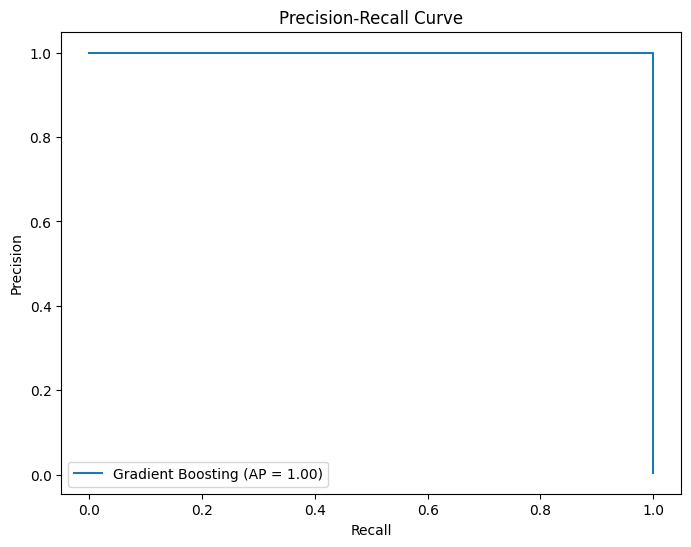


=== Training Logistic Regression ===
Cross-Validation ROC-AUC: 1.0000 ± 0.0000
Training time: 0.97 seconds

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     38833
        True       1.00      1.00      1.00       165

    accuracy                           1.00     38998
   macro avg       1.00      1.00      1.00     38998
weighted avg       1.00      1.00      1.00     38998

Confusion Matrix:
[[38833     0]
 [    0   165]]
ROC-AUC Score: 1.0000


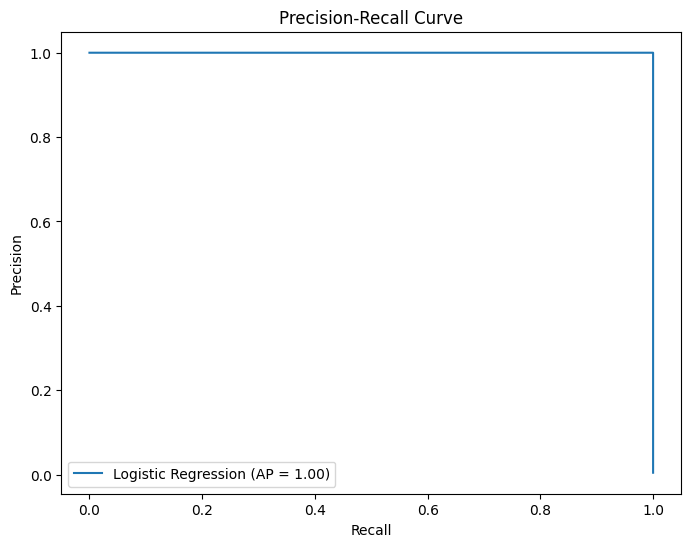

In [6]:
#Model Training and Evaluation
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    # Define models
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            class_weight=class_weight_dict,
            random_state=42,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            random_state=42
        ),
        'Logistic Regression': LogisticRegression(
            class_weight=class_weight_dict,
            random_state=42,
            max_iter=1000,
            n_jobs=-1
        )
    }

    results = {}

    for name, model in models.items():
        # Create pipeline with SMOTE for balancing
        pipeline = make_imb_pipeline(
            preprocessor,
            SMOTE(sampling_strategy=0.5, random_state=42),
            model
        )

        print(f"\n=== Training {name} ===")

        # Cross-validation
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        cv_scores = cross_val_score(pipeline, X_train, y_train,
                                   cv=cv, scoring='roc_auc', n_jobs=-1)
        print(f"Cross-Validation ROC-AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

        # Full training
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        train_time = time.time() - start_time
        print(f"Training time: {train_time:.2f} seconds")

        # Predictions
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]

        # Evaluation metrics
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"ROC-AUC Score: {roc_auc:.4f}")

        # Store results
        results[name] = {
            'model': pipeline,
            'roc_auc': roc_auc,
            'classification_report': classification_report(y_test, y_pred, output_dict=True),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'train_time': train_time
        }

        # Plot precision-recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'{name} (AP = {average_precision_score(y_test, y_proba):.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()

    return results

model_results = train_and_evaluate_models(X_train, y_train, X_test, y_test)

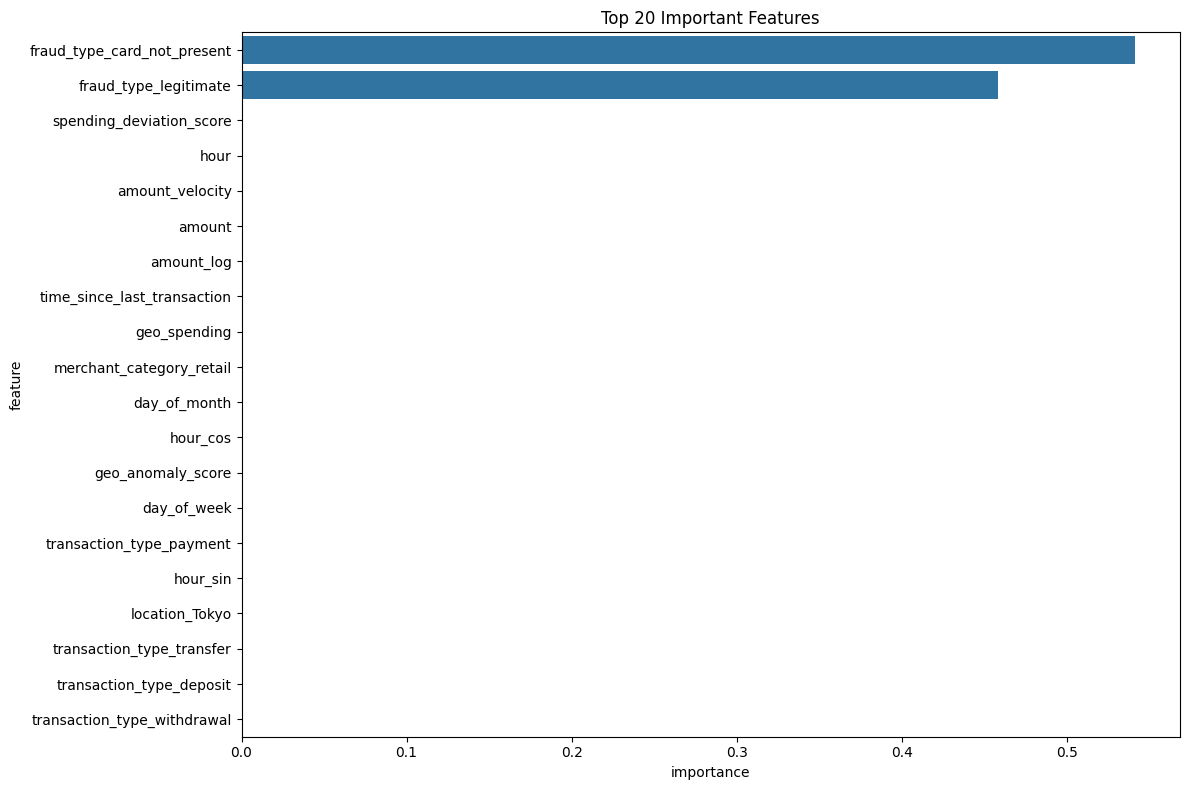

In [9]:
#Feature Importance Analysis
def plot_feature_importance(model, preprocessor, numerical_features, categorical_features, binary_features):
    """
    Plot feature importance for the model

    Parameters:
    - model: The trained pipeline model
    - preprocessor: The ColumnTransformer object
    - numerical_features: List of numerical feature names
    - categorical_features: List of categorical feature names
    - binary_features: List of binary feature names
    """
    try:
        # For imbalanced-learn pipeline, the preprocessor is in step 0
        if 'columntransformer' in model.named_steps:
            # Regular pipeline structure
            ct = model.named_steps['columntransformer']
        else:
            # Imbalanced-learn pipeline structure (step 0 is the preprocessor)
            ct = model.steps[0][1]

        # Get transformed categorical feature names
        categorical_features_transformed = ct.named_transformers_['cat'].get_feature_names_out(categorical_features)

        all_features = np.concatenate([
            numerical_features,
            categorical_features_transformed,
            binary_features
        ])

        # Get feature importances
        if hasattr(model.steps[-1][1], 'feature_importances_'):
            importances = model.steps[-1][1].feature_importances_
        else:
            print("Model doesn't have feature importance attribute")
            return

        # Create DataFrame
        feature_importance = pd.DataFrame({
            'feature': all_features,
            'importance': importances
        }).sort_values('importance', ascending=False)

        # Plot top 20 features
        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature',
                    data=feature_importance.head(20))
        plt.title('Top 20 Important Features')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error plotting feature importance: {str(e)}")
        raise

# Define your feature lists (these should be defined earlier in your code)
numerical_features = ['amount', 'time_since_last_transaction', 'spending_deviation_score',
                     'velocity_score', 'geo_anomaly_score', 'hour', 'day_of_week',
                     'day_of_month', 'amount_log', 'hour_sin', 'hour_cos',
                     'amount_velocity', 'geo_spending']

categorical_features = ['transaction_type', 'merchant_category', 'location',
                       'device_used', 'payment_channel', 'fraud_type']

binary_features = ['high_velocity', 'high_geo', 'high_spending', 'is_night', 'is_weekend']

# Example for Gradient Boosting model
plot_feature_importance(
    model=model_results['Gradient Boosting']['model'],
    preprocessor=preprocessor,
    numerical_features=numerical_features,
    categorical_features=categorical_features,
    binary_features=binary_features
)


Fraud Alert! Transaction ID: T146524
Fraud Probability: 1.0000
Actual Fraud: True
Transaction Details:
{'transaction_id': 'T146524', 'timestamp': '2023-02-25T18:37:40.375710', 'sender_account': 'ACC491789', 'receiver_account': 'ACC284843', 'amount': 20.07, 'transaction_type': 'transfer', 'merchant_category': 'retail', 'location': 'New York', 'device_used': 'mobile', 'time_since_last_transaction': -3131.519123126389, 'spending_deviation_score': -0.34, 'velocity_score': 10, 'geo_anomaly_score': 0.51, 'payment_channel': 'wire_transfer', 'ip_address': '239.189.127.66', 'device_hash': 'D2943300'}

Fraud Alert! Transaction ID: T222706
Fraud Probability: 1.0000
Actual Fraud: True
Transaction Details:
{'transaction_id': 'T222706', 'timestamp': '2023-11-06T18:29:30.279030', 'sender_account': 'ACC467296', 'receiver_account': 'ACC392502', 'amount': 17.15, 'transaction_type': 'transfer', 'merchant_category': 'travel', 'location': 'Singapore', 'device_used': 'web', 'time_since_last_transaction': 2

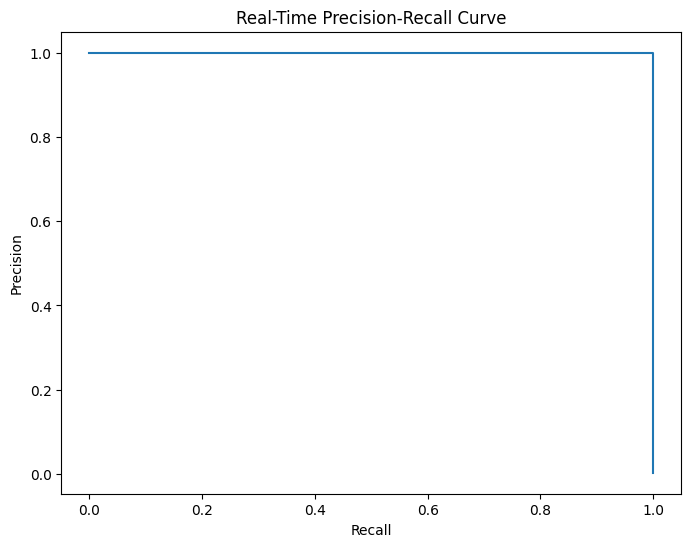

In [10]:
#Real-Time Fraud Detection Simulation
class RealTimeFraudDetector:
    def __init__(self, model, preprocessor, threshold=0.5):
        self.model = model
        self.preprocessor = preprocessor
        self.threshold = threshold
        self.transaction_history = deque(maxlen=1000)
        self.fraud_history = deque(maxlen=1000)

    def process_transaction(self, transaction_df):
        """Process a single transaction in real-time"""
        # Preprocess the transaction
        processed = preprocess_data(transaction_df.copy())
        processed = feature_engineering(processed)

        # Store in history
        self.transaction_history.append(processed.iloc[0].to_dict())

        # Make prediction
        features = processed.drop('is_fraud', axis=1, errors='ignore')
        proba = self.model.predict_proba(features)[0, 1]
        is_fraud = proba >= self.threshold

        # Store fraud prediction
        result = {
            'transaction_id': transaction_df['transaction_id'].iloc[0],
            'probability': proba,
            'prediction': is_fraud,
            'actual': transaction_df['is_fraud'].iloc[0] if 'is_fraud' in transaction_df else None,
            'timestamp': datetime.now()
        }
        self.fraud_history.append(result)

        return result

    def evaluate_performance(self):
        """Evaluate performance on detected frauds (if actual labels are available)"""
        if not self.fraud_history or not any('actual' in x and x['actual'] is not None for x in self.fraud_history):
            print("No labeled transactions to evaluate")
            return

        df = pd.DataFrame(self.fraud_history)
        df = df[df['actual'].notna()]

        if len(df) == 0:
            print("No labeled transactions to evaluate")
            return

        print("\n=== Real-Time Performance ===")
        print(f"Total Transactions Processed: {len(self.transaction_history)}")
        print(f"Fraudulent Transactions Detected: {len(df[df['prediction']])}")
        print(f"Actual Fraudulent Transactions: {len(df[df['actual']])}")

        if len(df[df['actual']]) > 0:
            print("\nClassification Report:")
            print(classification_report(df['actual'], df['prediction']))

            print("Confusion Matrix:")
            print(confusion_matrix(df['actual'], df['prediction']))

            print(f"ROC-AUC Score: {roc_auc_score(df['actual'], df['probability']):.4f}")

            # Plot precision-recall curve
            precision, recall, _ = precision_recall_curve(df['actual'], df['probability'])
            plt.figure(figsize=(8, 6))
            plt.plot(recall, precision)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Real-Time Precision-Recall Curve')
            plt.show()

# Initialize the detector with the best model
best_model = model_results['Gradient Boosting']['model']
detector = RealTimeFraudDetector(best_model, preprocessor, threshold=0.4)

# Simulate real-time processing
sample_transactions = df.sample(1000, random_state=42)

for _, row in sample_transactions.iterrows():
    transaction_df = pd.DataFrame([row])
    result = detector.process_transaction(transaction_df)

    if result['prediction']:
        print(f"\nFraud Alert! Transaction ID: {result['transaction_id']}")
        print(f"Fraud Probability: {result['probability']:.4f}")
        print(f"Actual Fraud: {result['actual']}")
        print("Transaction Details:")
        print(transaction_df.drop(['is_fraud', 'fraud_type'], axis=1, errors='ignore').to_dict('records')[0])

        # Here you would typically add logic to block the transaction or flag for review
        time.sleep(0.1)  # Simulate processing delay

# Evaluate performance
detector.evaluate_performance()

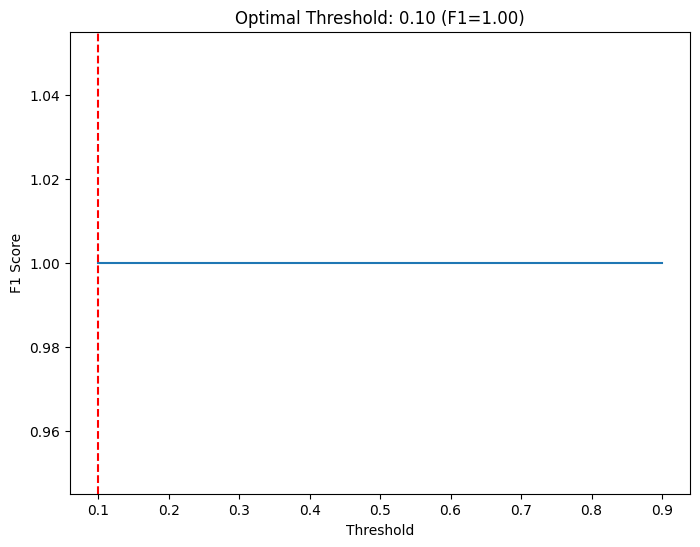

Optimal Threshold: 0.1000


In [11]:
#Model Optimization and Threshold Tuning
def optimize_threshold(model, X_val, y_val):
    """Find optimal threshold based on validation set"""
    y_proba = model.predict_proba(X_val)[:, 1]

    thresholds = np.linspace(0.1, 0.9, 50)
    f1_scores = [f1_score(y_val, y_proba >= t) for t in thresholds]

    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_f1 = f1_scores[optimal_idx]

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, f1_scores)
    plt.axvline(optimal_threshold, color='red', linestyle='--')
    plt.title(f'Optimal Threshold: {optimal_threshold:.2f} (F1={optimal_f1:.2f})')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.show()

    return optimal_threshold

# Split validation set from test set
X_val, X_test_final, y_val, y_test_final = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)

# Get optimal threshold
optimal_threshold = optimize_threshold(best_model, X_val, y_val)
print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Update detector with optimal threshold
detector.threshold = optimal_threshold


=== Final Model Evaluation ===
Threshold: 0.1000

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     19417
        True       1.00      1.00      1.00        82

    accuracy                           1.00     19499
   macro avg       1.00      1.00      1.00     19499
weighted avg       1.00      1.00      1.00     19499

Confusion Matrix:
[[19417     0]
 [    0    82]]

ROC-AUC Score: 1.0000


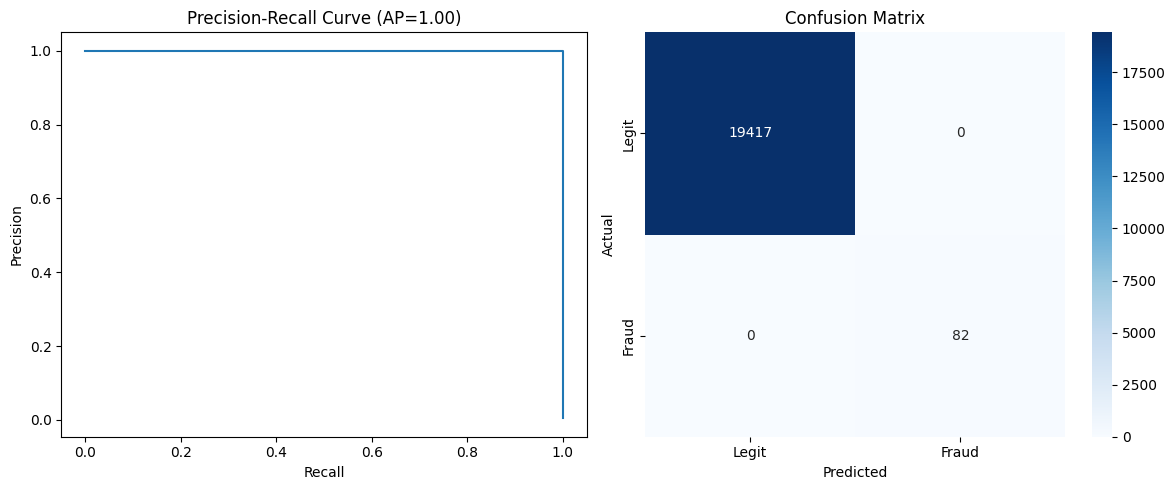

In [12]:
#Final Model Evaluation
def final_evaluation(model, X_test, y_test, threshold=0.5):
    """Comprehensive evaluation of the final model"""
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    print("\n=== Final Model Evaluation ===")
    print(f"Threshold: {threshold:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (AP={ap:.2f})')

    # Confusion matrix heatmap
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legit', 'Fraud'],
                yticklabels=['Legit', 'Fraud'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

    return {
        'roc_auc': roc_auc,
        'average_precision': ap,
        'confusion_matrix': cm,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

final_metrics = final_evaluation(best_model, X_test_final, y_test_final, optimal_threshold)

In [13]:
#Model Persistence
import joblib

def save_model_pipeline(model, filepath):
    """Save the entire model pipeline to disk"""
    joblib.dump(model, filepath)
    print(f"Model saved to {filepath}")

def load_model_pipeline(filepath):
    """Load model pipeline from disk"""
    model = joblib.load(filepath)
    print("Model loaded successfully")
    return model

# Save the best model
save_model_pipeline(best_model, 'fraud_detection_model.pkl')

# Example of loading the model
# loaded_model = load_model_pipeline('fraud_detection_model.pkl')

Model saved to fraud_detection_model.pkl


In [14]:
#Production Integration Example
class FraudDetectionAPI:
    """Example class showing how the model could be integrated into a production system"""

    def __init__(self, model_path):
        self.model = load_model_pipeline(model_path)
        self.preprocessor = preprocessor  # Would need to be saved/loaded as well in a real scenario
        self.threshold = optimal_threshold
        self.fraud_log = []

    def process_transaction(self, transaction_data):
        """Process a transaction received via API"""
        # Convert input data to DataFrame
        transaction_df = pd.DataFrame([transaction_data])

        # Preprocess and feature engineering
        processed = preprocess_data(transaction_df.copy())
        processed = feature_engineering(processed)

        # Make prediction
        features = processed.drop('is_fraud', axis=1, errors='ignore')
        proba = self.model.predict_proba(features)[0, 1]
        is_fraud = proba >= self.threshold

        # Log the result
        result = {
            'transaction_id': transaction_data.get('transaction_id'),
            'timestamp': datetime.now().isoformat(),
            'probability': float(proba),
            'is_fraud': bool(is_fraud),
            'features': features.to_dict('records')[0]
        }
        self.fraud_log.append(result)

        # Return response
        response = {
            'transaction_id': transaction_data.get('transaction_id'),
            'fraud_prediction': is_fraud,
            'fraud_probability': proba,
            'threshold': self.threshold,
            'decision': 'block' if is_fraud else 'allow'
        }

        return response

    def get_fraud_stats(self, last_n=100):
        """Get statistics on recent fraud predictions"""
        if not self.fraud_log:
            return {'total_transactions': 0, 'fraudulent': 0, 'fraud_rate': 0.0}

        recent = self.fraud_log[-last_n:]
        total = len(recent)
        fraud = sum(1 for x in recent if x['is_fraud'])

        return {
            'total_transactions': total,
            'fraudulent': fraud,
            'fraud_rate': fraud / total if total > 0 else 0.0,
            'average_confidence': np.mean([x['probability'] for x in recent if x['is_fraud']]) if fraud > 0 else 0.0
        }

# Example usage
# api = FraudDetectionAPI('fraud_detection_model.pkl')
# transaction_example = df.iloc[0].to_dict()
# response = api.process_transaction(transaction_example)
# print(response)